In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torchinfo
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据载入

In [3]:
# 定义数据集和数据加载器
data_dir = 'D:/数据集/磁瓦/网上数据集/磁瓦表面缺陷数据库'  # 替换为您的数据集路径


train_transform = transforms.Compose([
    transforms.Resize((128, 128)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 数据加载

In [4]:
pretrain_dir = 'C:/Users/SHANGXINGWANG/Downloads/main'
pretrain_dataset = datasets.ImageFolder(root=f'{pretrain_dir}/data', transform=train_transform)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)

train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# GhostNet

In [5]:
class DWConv3x3BNReLU(nn.Sequential):
    def __init__(self, in_channel, out_channel, stride, groups, dilation=1):  # 加入 dilation 参数，默认值为1
        super(DWConv3x3BNReLU, self).__init__(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, groups=groups, bias=False),  # 使用 dilation
            nn.BatchNorm2d(out_channel),
            nn.ReLU6(inplace=True),
        )

class SqueezeAndExcite(nn.Module):
    def __init__(self, in_channel, out_channel, divide=4):
        super(SqueezeAndExcite, self).__init__()
        mid_channel = in_channel // divide
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.SEblock = nn.Sequential(
            nn.Linear(in_features=in_channel, out_features=mid_channel),
            nn.ReLU6(inplace=True),
            nn.Linear(in_features=mid_channel, out_features=out_channel),
            nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        b, c, h, w = x.size()
        out = self.pool(x)
        out = torch.flatten(out, start_dim=1)
        out = self.SEblock(out)
        out = out.view(b, c, 1, 1)
        return out * x

class GhostBottleneck(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, kernel_size, stride, use_se):
        super(GhostBottleneck, self).__init__()
        self.stride = stride

        self.bottleneck = nn.Sequential(
            GhostModule(in_channel=in_channel, out_channel=mid_channel, use_relu=True),
            DWConv3x3BNReLU(in_channel=mid_channel, out_channel=mid_channel, stride=stride, groups=mid_channel) if self.stride > 1 else nn.Sequential(),
            SqueezeAndExcite(in_channel=mid_channel, out_channel=mid_channel) if use_se else nn.Sequential(),
            GhostModule(in_channel=mid_channel, out_channel=out_channel, use_relu=False)
        )

        if self.stride > 1:
            self.shortcut = DWConv3x3BNReLU(in_channel=in_channel, out_channel=out_channel, stride=stride, groups=1)
        else:
            self.shortcut = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1)

    def forward(self, x):
        # print(f"Input to bottleneck: {x.shape}")  # 打印输入通道数
        out = self.bottleneck(x)
        residual = self.shortcut(x)
        out += residual   # 残差连接
        # print(f"Output of bottleneck: {out.shape}")  # 打印输出通道数
        return out

class GhostModule(nn.Module):
    def __init__(self, in_channel, out_channel, s=2, kernel_size=1, stride=1, use_relu=True):
        super(GhostModule, self).__init__()
        intrinsic_channel = out_channel // s  # 原始特征通道数
        ghost_channel = out_channel - intrinsic_channel  # Ghost 特征通道数

        # 原始特征图的主卷积层
        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=intrinsic_channel, kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2, bias=False),
            nn.BatchNorm2d(intrinsic_channel),
            nn.ReLU(inplace=True) if use_relu else nn.Sequential()
        )

        # Ghost 特征图的 cheap_op 使用不同的空洞率来实现多尺度卷积
        # 注意 out_channel 和 groups 需要保持一致
        self.cheap_op_1 = DWConv3x3BNReLU(in_channel=intrinsic_channel, out_channel=ghost_channel, stride=1, groups=intrinsic_channel, dilation=1)
        self.cheap_op_2 = DWConv3x3BNReLU(in_channel=intrinsic_channel, out_channel=ghost_channel, stride=1, groups=intrinsic_channel, dilation=2)

    def forward(self, x):
        # 原始特征
        x1 = self.primary_conv(x)

        # 通过两个不同膨胀率的卷积获取多尺度 Ghost 特征
        x2 = self.cheap_op_1(x1)
        x3 = self.cheap_op_2(x1)

        # 将原始特征和两组 Ghost 特征拼接在一起
        out = torch.cat([x1, x2], dim=1)  # 确保拼接后的输出通道数与预期一致
        return out


class GhostNet(nn.Module):
    def __init__(self, num_classes=6):  # 设置 num_classes 为 6
        super(GhostNet, self).__init__()

        self.first_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),
        )

        ghost_model_setting = [
            # in, mid, out, kernel, stride, use_se
            [16, 16, 16, 3, 1, False],
            [16, 48, 24, 3, 2, False],
            [24, 72, 24, 3, 1, False],
            [24, 72, 40, 5, 2, True],
            [40, 120, 40, 5, 1, True],
            [40, 240, 80, 3, 2, False],
            [80, 200, 80, 3, 1, False],
            [80, 184, 80, 3, 1, False],
            [80, 184, 80, 3, 1, False],
            [80, 480, 112, 3, 1, True],
            [112, 672, 112, 3, 1, True],
            [112, 672, 160, 5, 2, True],
            [160, 960, 160, 5, 1, False],
            [160, 960, 160, 5, 1, True],
            [160, 960, 160, 5, 1, False],
            [160, 960, 160, 5, 1, True],
        ]

        layers = []
        for in_channel, mid_channel, out_channel, kernel_size, stride, use_se in ghost_model_setting:
            layers.append(GhostBottleneck(in_channel=in_channel, mid_channel=mid_channel, out_channel=out_channel, kernel_size=kernel_size, stride=stride, use_se=use_se))

        self.features = nn.Sequential(*layers)

        self.last_stage = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=960, kernel_size=1, stride=1),
            nn.BatchNorm2d(960),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels=960, out_channels=1280, kernel_size=1, stride=1),
            nn.ReLU6(inplace=True)
        )

        self.classifier = nn.Linear(in_features=1280, out_features=num_classes)

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        x = self.first_conv(x)
        # print(f"After first_conv: {x.shape}")
        x = self.features(x)
        # print(f"After features: {x.shape}")
        x = self.last_stage(x)
        # print(f"After last_stage: {x.shape}")
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        # print(f"After classifier: {x.shape}")
        return x

# FPN

In [6]:
class FPN(nn.Module):
    def __init__(self, features_channels, out_channels):
        super(FPN, self).__init__()
        self.feat_channels = features_channels
        self.out_channels = out_channels
        self.lateral_convs = nn.ModuleList([nn.Conv2d(c, out_channels, 1) for c in features_channels])
        self.output_convs = nn.ModuleList([nn.Conv2d(out_channels, out_channels, 3, padding=1) for _ in features_channels])

    def _upsample_add(self, top, lateral):
        _, _, H, W = lateral.size()
        return F.interpolate(top, size=(H, W), mode='nearest') + lateral

    def forward(self, features):
        # 假设features是一个包含多个特征图的列表
        laterals = [lateral_conv(feature) for feature, lateral_conv in zip(features, self.lateral_convs)]
        # 从上到下，逐步将特征图相加
        for i in range(len(laterals) - 1, 0, -1):
            laterals[i - 1] += self._upsample_add(laterals[i], laterals[i-1])
        outputs = [output_conv(lateral) for lateral, output_conv in zip(laterals, self.output_convs)]
        return outputs

# 通道分离和通道排序

In [7]:
class ChannelSplit(nn.Module):
    def __init__(self, split_size):
        super(ChannelSplit, self).__init__()
        self.split_size = split_size

    def forward(self, x):
        return torch.split(x, self.split_size, dim=1)

class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super(ChannelShuffle, self).__init__()
        self.groups = groups

    def forward(self, x):
        batch_size, num_channels, height, width = x.size()
        channels_per_group = num_channels // self.groups
        x = x.view(batch_size, self.groups, channels_per_group, height, width)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, height, width)
        return x

In [8]:
# 深度可分离瓶颈层

In [9]:
class DepthwiseSeparableConv_001(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, dilation=1, use_relu=True):
        super(DepthwiseSeparableConv_001, self).__init__()
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=in_channel, kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2 * dilation, dilation=dilation, groups=in_channel, bias=False),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(inplace=True) if use_relu else nn.Sequential()
        )
        self.pointwise_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True) if use_relu else nn.Sequential()
        )

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x

# 通道混洗

# Swish

In [10]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

# LabelSmoothing

In [11]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, classes, smoothing, dim=-1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=self.dim)
        weight = input.new_ones(input.size()) * self.smoothing / (self.cls - 1.)
        weight.scatter_(self.dim, target.unsqueeze(self.dim), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=self.dim)
        return loss.mean()

# CBAM注意力机制

In [12]:
class ChannelAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(num_channels, num_channels // reduction_ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(num_channels // reduction_ratio, num_channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd."
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(num_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# EAC通道注意力机制

In [13]:
class ECA(nn.Module):
    def __init__(self, k_size=3):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).squeeze(-1).transpose(-1, -2)  # 将特征图转换适用于1D卷积的形式
        y = self.conv(y).transpose(-1, -2).unsqueeze(-1)  # 应用1D卷积并调整形状
        y = self.sigmoid(y)
        return x * y.expand_as(x)

# S-GhostNet

In [14]:
class DWConv3x3BNReLU_001(nn.Sequential):
    def __init__(self, in_channel, out_channel, stride, groups, dilation=1):
        super(DWConv3x3BNReLU_001, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=in_channel, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, groups=in_channel, bias=False),
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
            # nn.ReLU6(inplace=True)
            Swish()
        )
        # 如果通道数或步长不一致，则需要在跳跃连接路径中添加卷积
        if in_channel != out_channel or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.shortcut = nn.Identity()  # 如果通道数一致，直接传递输入

    def forward(self, x):
        residual = self.shortcut(x)  # 跳跃路径
        out = self.conv(x)  # 主路径
        out += residual  # 主路径与跳跃路径相加
        return out

class SqueezeAndExcite_001(nn.Module):
    def __init__(self, in_channel, out_channel, divide=4):
        super(SqueezeAndExcite_001, self).__init__()
        mid_channel = in_channel // divide
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.SEblock = nn.Sequential(
            nn.Linear(in_features=in_channel, out_features=mid_channel, bias=False),
            # nn.ReLU(inplace=True),
            Swish(),
            nn.Linear(in_features=mid_channel, out_features=out_channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, h, w = x.size()
        out = self.pool(x)
        out = torch.flatten(out, start_dim=1)
        out = self.SEblock(out)
        out = out.view(b, c, 1, 1)
        return out * x


class GhostBottleneck_001(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, stride=1, kernel_size=3, use_se=True, use_cbam=False, use_eca=True):
        super(GhostBottleneck_001, self).__init__()
        self.stride = stride
        self.mid_channel = mid_channel
        self.out_channel = out_channel
        self.use_se = use_se
        self.use_cbam = use_cbam
        self.use_eca = use_eca
        

        self.use_residual = (stride == 1 and in_channel == out_channel)

        self.shortcut = nn.Sequential()
        if not self.use_residual:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_channel)
            )

        if self.use_se:
            self.se_module = SqueezeAndExcite_001(mid_channel, out_channel)
        if self.use_cbam:
            self.cbam_module = CBAM(out_channel)
        if self.use_eca:
            self.eca_module = ECA(k_size=3)  # 初始化ECA模块

        # 使用深度可分离卷积替换primary_conv
        self.depthwise_separable_conv = DepthwiseSeparableConv_001(in_channel, mid_channel, kernel_size, stride)


        self.bottleneck = nn.Sequential(
            GhostModule_001(in_channel, mid_channel, s=2, kernel_size=1, stride=1, use_relu=True, use_eca=self.use_eca),
            nn.Conv2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=mid_channel, bias=False),
            nn.BatchNorm2d(mid_channel),
            # nn.ReLU(inplace=True) if stride == 1 else nn.Sequential(),
            Swish() if stride == 1 else nn.Sequential(),
            GhostModule_001(mid_channel, out_channel, s=2, kernel_size=1, stride=1, use_relu=False, use_eca=self.use_eca),
            nn.Dropout(p=0.2)  # 添加Dropout层，p为Dropout概率
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.bottleneck(x)
        
        if self.use_se:
            out = self.se_module(out)
        if self.use_cbam:
            out = self.cbam_module(out)
        if self.use_eca:
            out = self.eca_module(out)
        
        if self.use_residual:
            out = out + residual
        return out


class GhostModule_001(nn.Module):
    def __init__(self, in_channel, out_channel, s=2, kernel_size=1, stride=1, use_relu=True, use_eca=True):
        super(GhostModule_001, self).__init__()

        intrinsic_channel = out_channel // s
        ghost_channel = out_channel - intrinsic_channel

        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=intrinsic_channel, kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2, bias=False),
            nn.BatchNorm2d(intrinsic_channel),
            Swish() if use_relu else nn.Sequential()
        )

        self.cheap_op_1 = nn.Sequential(
            nn.Conv2d(in_channels=intrinsic_channel, out_channels=ghost_channel, kernel_size=3, stride=1, padding=1, groups=intrinsic_channel, bias=False),
            nn.BatchNorm2d(ghost_channel),
            Swish() if use_relu else nn.Sequential()
        )

        # 添加通道混洗操作后的 cheap_op_2
        self.cheap_op_2 = nn.Sequential(
            nn.Conv2d(in_channels=intrinsic_channel, out_channels=ghost_channel, kernel_size=3, stride=1, padding=2, dilation=2, groups=intrinsic_channel, bias=False),
            nn.BatchNorm2d(ghost_channel),
            Swish() if use_relu else nn.Sequential()
        )
        
        self.channel_adjust = nn.Conv2d(in_channels=intrinsic_channel + 2 * ghost_channel, out_channels=out_channel, kernel_size=1, stride=1, padding=0, bias=False)

        if use_eca:
            self.eca = ECA(k_size=3)  # 初始化ECA模块

    def _channel_shuffle(self, x, groups):
        batchsize, num_channels, height, width = x.size()
        channels_per_group = num_channels // groups

        # reshape
        x = x.view(batchsize, groups, channels_per_group, height, width)

        # transpose
        x = x.permute(0, 2, 1, 3, 4).contiguous()

        # flatten
        x = x.view(batchsize, -1, height, width)

        return x

    def forward(self, x):
        x1 = self.primary_conv(x)
        
        x2 = self.cheap_op_1(x1)
        x3 = self.cheap_op_2(x1)

        x_cat = torch.cat([x1, x2, x3], dim=1)
        out = self._channel_shuffle(x_cat, groups=4)  # 使用 4 组作为示例

        if hasattr(self, 'eca'):  
            out = self.eca(out)

        out = self.channel_adjust(out)
        return out




class S_GhostNet(nn.Module):
    def __init__(self, num_classes):
        super(S_GhostNet, self).__init__()
        self.first_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # 定义 GhostNet 的设置
        ghost_model_setting = [
            [16, 16, 16, 3, 1, False],
            [16, 24, 24, 3, 2, False],
            [24, 24, 24, 3, 1, False],
            [24, 40, 40, 3, 2, True],
            [40, 40, 40, 3, 1, True],
            [40, 80, 80, 3, 2, False],
            [80, 80, 80, 3, 1, False],
            [80, 112, 112, 3, 1, True],
            [112, 112, 112, 3, 1, True],
            [112, 160, 160, 3, 2, True],
            [160, 160, 160, 3, 1, True]
        ]

        layers = []
        for in_channel, mid_channel, out_channel, kernel_size, stride, use_se in ghost_model_setting:
            layers.append(GhostBottleneck_001(in_channel=in_channel, mid_channel=mid_channel, out_channel=out_channel, kernel_size=kernel_size, stride=stride, use_se=use_se))

        self.features = nn.Sequential(*layers)
        

        self.last_stage = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=960, kernel_size=1, stride=1),
            nn.BatchNorm2d(960),
            nn.ReLU6(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=0.5),  # 添加Dropout层，p为Dropout概率
            nn.Linear(960, num_classes),
            nn.ReLU6(inplace=True)
        )

        self.fpn = FPN(features_channels=[160], out_channels=160)

        # 修改最后的分类器部分以适应FPN的输出
        self.classifier = nn.Linear(in_features=2560, out_features=num_classes)

    def forward(self, x):
        x = self.first_conv(x)
        # print("After first_conv:", x.shape)  # 打印尺寸
    
        for i, layer in enumerate(self.features):
            x = layer(x)
            # print(f"After feature layer {i+1}:", x.shape)  # 打印尺寸
    
        fpn_features = self.fpn([x])  # 使用最后一层的特征图作为FPN的输入
        # print("After FPN:", fpn_features[0].shape)  # 打印FPN输出的尺寸
    
        x = torch.cat([torch.flatten(feature, start_dim=1) for feature in fpn_features], dim=1)
        x = self.classifier(x)
        return x

# 改进模型载入

In [15]:
ghost_model = GhostNet(num_classes=6)  # 将 GhostNet 类别数设置为 6
ghost_001_model = S_GhostNet(num_classes=6)  # 将 GhostNet 类别数设置为 6

# 模型加载

In [16]:
model_names = ['Ghost','S_GhostNet','EfficientNet', 'MobileNetV2', 'DenseNet121', 'ResNet', 'ShuffleNetV2']
model_dict = {
    'EfficientNet': models.efficientnet_b0(pretrained=True),
    'Ghost' : ghost_model,
    'S_GhostNet' : ghost_001_model,
    'MobileNetV2': models.mobilenet_v2(pretrained=True),
    'DenseNet121': models.densenet121(pretrained=True),
    # 'MnasNet': models.mnasnet1_0(pretrained=True),
    #'MixNet': models.mixnet_s,
    'ResNet': models.resnet50(pretrained=True),
    'ShuffleNetV2': models.shufflenet_v2_x1_0(pretrained=True)
}


# results = {model_name: {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None} for model_name in model_names}

# 初始化结果存储字典
results = {
    'EfficientNet': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None},
    'MobileNetV2': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None},
    'DenseNet121': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None},
    # 'MnasNet': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None},
    'Ghost': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None},
    'S_GhostNet': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None},
    'ResNet': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None},
    'ShuffleNetV2': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': [], 'params': None, 'flops': None}
}

# print(model_dict['ShuffleNetV2'](pretrained=True))

D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` 

# 测试集评估

In [17]:
# 定义评估函数
def evaluate(loader, model):
    model.eval()
    # model.to(device)
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return accuracy, precision, recall, f1

# 训练

In [18]:
# 外部只进行一次模型遍历，没有嵌套
for model_name in model_dict:
    print(f"Training {model_name}...")
    model = model_dict[model_name]
    model = model.to(device)

    # 进行正式训练和评估
    print(f"Training {model_name} with fine-tuning...")
    
    if model_name == 'S_GhostNet':
        model.load_state_dict(torch.load(f'{model_name}_1.pth'))   

    # 修改最后的分类层
    if model_name in ['EfficientNet', 'MobileNetV2']:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6).to(device)
    elif model_name in ['DenseNet121']:
        model.classifier = nn.Linear(model.classifier.in_features, 6).to(device)
    elif model_name in ['ResNet', 'ShuffleNetV2']:
        model.fc = nn.Linear(model.fc.in_features, 6).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 100

    best_model_wts = None
    best_accuracy = 0.0
    best_epoch = 0

    # 初始化测试集指标列表
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1_scores = []

    all_labels = []
    all_predicted = []
    
    for epoch in range(epochs):  
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # 每个epoch结束后进行训练集和测试集的评估
        train_accuracy, train_precision, train_recall, train_f1 = evaluate(train_loader, model)
        test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader, model)

        # 打印结果
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train - Accuracy: {train_accuracy:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1-score: {train_f1:.4f}')
        print(f'Test  - Accuracy: {test_accuracy:.4f} | Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1-score: {test_f1:.4f}')
        # print(f'Params (M): {model_params / 1e6:.2f}')

        # 检查当前测试集准确率是否最高
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_epoch = epoch
            best_model_wts = model.state_dict()  # 保存最优模型权重
        
        # 存储每个epoch的测试结果到该模型的结果字典
        results[model_name]['accuracies'].append(test_accuracy)
        results[model_name]['precisions'].append(test_precision)
        results[model_name]['recalls'].append(test_recall)
        results[model_name]['f1_scores'].append(test_f1)       
        # print(f'Epoch {epoch+1}, {model_name}, Test Loss: {test_loss / len(test_loader)}, Test Acc: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1: {test_f1}')

    # 训练结束后恢复最优模型权重
    model.load_state_dict(best_model_wts)

    # 保存最优模型状态到文件
    torch.save(best_model_wts, f'{model_name}_best_model.pth')
    print(f'Saved best model for {model_name} from epoch {best_epoch+1} with accuracy {best_accuracy:.4f}')

    # 计算模型参数和浮点运算次数
    model.to('cuda')
    summary_results = torchinfo.summary(model, input_size=(64, 3, 128, 128), device='cuda')
    model.to('cpu')

    # 存储模型参数和 FLOPs
    results[model_name]['params'] = summary_results.total_params / 1e6  # 参数数以百万为单位
    results[model_name]['flops'] = summary_results.total_mult_adds / 1e9  # FLOPs以十亿为单位

    print(f'{model_name} - Params (M): {results[model_name]["params"]:.2f}, Flops (G): {results[model_name]["flops"]:.2f}')

Training EfficientNet...
Training EfficientNet with fine-tuning...
Epoch 1/100
Train - Accuracy: 0.9139 | Precision: 0.8618 | Recall: 0.7190 | F1-score: 0.7526
Test  - Accuracy: 0.8672 | Precision: 0.8388 | Recall: 0.6359 | F1-score: 0.6659
Epoch 2/100
Train - Accuracy: 0.9719 | Precision: 0.9346 | Recall: 0.9178 | F1-score: 0.9233
Test  - Accuracy: 0.9594 | Precision: 0.9448 | Recall: 0.9001 | F1-score: 0.9185
Epoch 3/100
Train - Accuracy: 0.9719 | Precision: 0.9592 | Recall: 0.9323 | F1-score: 0.9439
Test  - Accuracy: 0.9373 | Precision: 0.9211 | Recall: 0.8525 | F1-score: 0.8779
Epoch 4/100
Train - Accuracy: 0.9841 | Precision: 0.9583 | Recall: 0.9672 | F1-score: 0.9618
Test  - Accuracy: 0.9336 | Precision: 0.8751 | Recall: 0.8611 | F1-score: 0.8592
Epoch 5/100
Train - Accuracy: 0.9963 | Precision: 0.9952 | Recall: 0.9827 | F1-score: 0.9887
Test  - Accuracy: 0.9852 | Precision: 0.9876 | Recall: 0.9682 | F1-score: 0.9775
Epoch 6/100
Train - Accuracy: 0.9972 | Precision: 0.9913 | Reca

D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
Train - Accuracy: 0.7091 | Precision: 0.1186 | Recall: 0.1660 | F1-score: 0.1384
Test  - Accuracy: 0.6974 | Precision: 0.1175 | Recall: 0.1649 | F1-score: 0.1373


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100
Train - Accuracy: 0.7035 | Precision: 0.1518 | Recall: 0.1701 | F1-score: 0.1479
Test  - Accuracy: 0.6937 | Precision: 0.1595 | Recall: 0.1782 | F1-score: 0.1596


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100
Train - Accuracy: 0.7081 | Precision: 0.1642 | Recall: 0.1712 | F1-score: 0.1489
Test  - Accuracy: 0.7085 | Precision: 0.2846 | Recall: 0.1746 | F1-score: 0.1533


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100
Train - Accuracy: 0.7044 | Precision: 0.1442 | Recall: 0.1685 | F1-score: 0.1448
Test  - Accuracy: 0.6937 | Precision: 0.1595 | Recall: 0.1782 | F1-score: 0.1596


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100
Train - Accuracy: 0.7081 | Precision: 0.1504 | Recall: 0.1722 | F1-score: 0.1507
Test  - Accuracy: 0.6937 | Precision: 0.2023 | Recall: 0.1711 | F1-score: 0.1521


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100
Train - Accuracy: 0.7268 | Precision: 0.1828 | Recall: 0.2148 | F1-score: 0.1962
Test  - Accuracy: 0.6863 | Precision: 0.1388 | Recall: 0.1751 | F1-score: 0.1543


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100
Train - Accuracy: 0.7184 | Precision: 0.1768 | Recall: 0.1809 | F1-score: 0.1633
Test  - Accuracy: 0.7085 | Precision: 0.1751 | Recall: 0.1803 | F1-score: 0.1619


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100
Train - Accuracy: 0.7156 | Precision: 0.1606 | Recall: 0.1835 | F1-score: 0.1654
Test  - Accuracy: 0.7122 | Precision: 0.1914 | Recall: 0.1875 | F1-score: 0.1725


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100
Train - Accuracy: 0.6978 | Precision: 0.2649 | Recall: 0.2328 | F1-score: 0.1863
Test  - Accuracy: 0.6421 | Precision: 0.1270 | Recall: 0.1648 | F1-score: 0.1425


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100
Train - Accuracy: 0.7680 | Precision: 0.2013 | Recall: 0.2929 | F1-score: 0.2317
Test  - Accuracy: 0.6716 | Precision: 0.1619 | Recall: 0.2162 | F1-score: 0.1839


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100
Train - Accuracy: 0.7100 | Precision: 0.1558 | Recall: 0.1710 | F1-score: 0.1487
Test  - Accuracy: 0.6974 | Precision: 0.1180 | Recall: 0.1649 | F1-score: 0.1376


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100
Train - Accuracy: 0.7297 | Precision: 0.2016 | Recall: 0.3094 | F1-score: 0.2219
Test  - Accuracy: 0.5867 | Precision: 0.1548 | Recall: 0.2152 | F1-score: 0.1670


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100
Train - Accuracy: 0.7671 | Precision: 0.2024 | Recall: 0.2783 | F1-score: 0.2322
Test  - Accuracy: 0.7048 | Precision: 0.1700 | Recall: 0.2113 | F1-score: 0.1883


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100
Train - Accuracy: 0.7568 | Precision: 0.4023 | Recall: 0.3005 | F1-score: 0.2650
Test  - Accuracy: 0.6863 | Precision: 0.1777 | Recall: 0.2011 | F1-score: 0.1858


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100
Train - Accuracy: 0.7699 | Precision: 0.2573 | Recall: 0.3355 | F1-score: 0.2731
Test  - Accuracy: 0.6679 | Precision: 0.1983 | Recall: 0.2459 | F1-score: 0.2126


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100
Train - Accuracy: 0.7530 | Precision: 0.2035 | Recall: 0.3101 | F1-score: 0.2278
Test  - Accuracy: 0.6199 | Precision: 0.1665 | Recall: 0.2422 | F1-score: 0.1816


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100
Train - Accuracy: 0.7886 | Precision: 0.4569 | Recall: 0.3534 | F1-score: 0.3096
Test  - Accuracy: 0.6531 | Precision: 0.3422 | Recall: 0.2761 | F1-score: 0.2891


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100
Train - Accuracy: 0.7933 | Precision: 0.4818 | Recall: 0.3515 | F1-score: 0.3217
Test  - Accuracy: 0.7011 | Precision: 0.2077 | Recall: 0.2257 | F1-score: 0.2081


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100
Train - Accuracy: 0.7792 | Precision: 0.3742 | Recall: 0.3131 | F1-score: 0.3111
Test  - Accuracy: 0.7048 | Precision: 0.1927 | Recall: 0.1947 | F1-score: 0.1841


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100
Train - Accuracy: 0.7961 | Precision: 0.3861 | Recall: 0.3613 | F1-score: 0.3592
Test  - Accuracy: 0.7085 | Precision: 0.2905 | Recall: 0.2590 | F1-score: 0.2612


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100
Train - Accuracy: 0.8344 | Precision: 0.5361 | Recall: 0.4664 | F1-score: 0.4313
Test  - Accuracy: 0.6827 | Precision: 0.2701 | Recall: 0.3158 | F1-score: 0.2877


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100
Train - Accuracy: 0.8503 | Precision: 0.4668 | Recall: 0.4879 | F1-score: 0.4542
Test  - Accuracy: 0.6974 | Precision: 0.2762 | Recall: 0.3047 | F1-score: 0.2883


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100
Train - Accuracy: 0.8251 | Precision: 0.4684 | Recall: 0.4414 | F1-score: 0.4335
Test  - Accuracy: 0.7454 | Precision: 0.3176 | Recall: 0.2982 | F1-score: 0.2986


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/100
Train - Accuracy: 0.8625 | Precision: 0.5561 | Recall: 0.5197 | F1-score: 0.4707
Test  - Accuracy: 0.6827 | Precision: 0.2519 | Recall: 0.2712 | F1-score: 0.2574


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100
Train - Accuracy: 0.8756 | Precision: 0.6615 | Recall: 0.5756 | F1-score: 0.5437
Test  - Accuracy: 0.6679 | Precision: 0.2698 | Recall: 0.2948 | F1-score: 0.2797


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100
Train - Accuracy: 0.8653 | Precision: 0.5572 | Recall: 0.6047 | F1-score: 0.5683
Test  - Accuracy: 0.6790 | Precision: 0.3410 | Recall: 0.3090 | F1-score: 0.3054


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100
Train - Accuracy: 0.8644 | Precision: 0.5588 | Recall: 0.6187 | F1-score: 0.5844
Test  - Accuracy: 0.6125 | Precision: 0.2491 | Recall: 0.2504 | F1-score: 0.2379


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/100
Train - Accuracy: 0.8644 | Precision: 0.5748 | Recall: 0.5322 | F1-score: 0.5042
Test  - Accuracy: 0.7232 | Precision: 0.3240 | Recall: 0.2886 | F1-score: 0.2975


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100
Train - Accuracy: 0.9008 | Precision: 0.6909 | Recall: 0.6101 | F1-score: 0.5815
Test  - Accuracy: 0.7159 | Precision: 0.2906 | Recall: 0.2676 | F1-score: 0.2720


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100
Train - Accuracy: 0.9055 | Precision: 0.6709 | Recall: 0.6365 | F1-score: 0.6260
Test  - Accuracy: 0.7122 | Precision: 0.3032 | Recall: 0.2661 | F1-score: 0.2710


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100
Train - Accuracy: 0.8868 | Precision: 0.6434 | Recall: 0.5997 | F1-score: 0.5650
Test  - Accuracy: 0.7011 | Precision: 0.3121 | Recall: 0.3650 | F1-score: 0.3335


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100
Train - Accuracy: 0.9130 | Precision: 0.6563 | Recall: 0.6950 | F1-score: 0.6655
Test  - Accuracy: 0.6531 | Precision: 0.4412 | Recall: 0.3237 | F1-score: 0.3262


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100
Train - Accuracy: 0.9027 | Precision: 0.6498 | Recall: 0.6613 | F1-score: 0.6458
Test  - Accuracy: 0.6937 | Precision: 0.2984 | Recall: 0.3257 | F1-score: 0.3092


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/100
Train - Accuracy: 0.9317 | Precision: 0.6848 | Recall: 0.7215 | F1-score: 0.6991
Test  - Accuracy: 0.7269 | Precision: 0.3068 | Recall: 0.2984 | F1-score: 0.3005


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/100
Train - Accuracy: 0.9392 | Precision: 0.7102 | Recall: 0.7432 | F1-score: 0.7236
Test  - Accuracy: 0.7417 | Precision: 0.4640 | Recall: 0.3372 | F1-score: 0.3718


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/100
Train - Accuracy: 0.9158 | Precision: 0.6725 | Recall: 0.6936 | F1-score: 0.6764
Test  - Accuracy: 0.6937 | Precision: 0.3799 | Recall: 0.3202 | F1-score: 0.3199


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100
Train - Accuracy: 0.8746 | Precision: 0.6249 | Recall: 0.6659 | F1-score: 0.6232
Test  - Accuracy: 0.6790 | Precision: 0.3713 | Recall: 0.3397 | F1-score: 0.3236


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100
Train - Accuracy: 0.9186 | Precision: 0.6623 | Recall: 0.7498 | F1-score: 0.6976
Test  - Accuracy: 0.7159 | Precision: 0.4174 | Recall: 0.3972 | F1-score: 0.3907


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100
Train - Accuracy: 0.9654 | Precision: 0.7572 | Recall: 0.8038 | F1-score: 0.7763
Test  - Accuracy: 0.7638 | Precision: 0.4221 | Recall: 0.3784 | F1-score: 0.3910


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100
Train - Accuracy: 0.9074 | Precision: 0.5775 | Recall: 0.6167 | F1-score: 0.5848
Test  - Accuracy: 0.6900 | Precision: 0.3012 | Recall: 0.2662 | F1-score: 0.2520


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/100
Train - Accuracy: 0.9514 | Precision: 0.7243 | Recall: 0.7754 | F1-score: 0.7472
Test  - Accuracy: 0.7048 | Precision: 0.3870 | Recall: 0.3294 | F1-score: 0.3274
Epoch 53/100
Train - Accuracy: 0.9560 | Precision: 0.7426 | Recall: 0.7929 | F1-score: 0.7626
Test  - Accuracy: 0.7712 | Precision: 0.4984 | Recall: 0.4262 | F1-score: 0.4472


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/100
Train - Accuracy: 0.9626 | Precision: 0.7624 | Recall: 0.7979 | F1-score: 0.7782
Test  - Accuracy: 0.7675 | Precision: 0.4562 | Recall: 0.3763 | F1-score: 0.3976


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100
Train - Accuracy: 0.9298 | Precision: 0.7106 | Recall: 0.7078 | F1-score: 0.6946
Test  - Accuracy: 0.7491 | Precision: 0.4470 | Recall: 0.3564 | F1-score: 0.3735


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100
Train - Accuracy: 0.9607 | Precision: 0.7473 | Recall: 0.8026 | F1-score: 0.7725
Test  - Accuracy: 0.7085 | Precision: 0.3723 | Recall: 0.3678 | F1-score: 0.3637


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100
Train - Accuracy: 0.9598 | Precision: 0.7463 | Recall: 0.7938 | F1-score: 0.7669
Test  - Accuracy: 0.7417 | Precision: 0.3952 | Recall: 0.3578 | F1-score: 0.3712
Epoch 58/100
Train - Accuracy: 0.9074 | Precision: 0.7162 | Recall: 0.6922 | F1-score: 0.6911
Test  - Accuracy: 0.7491 | Precision: 0.4934 | Recall: 0.3885 | F1-score: 0.4133
Epoch 59/100
Train - Accuracy: 0.9532 | Precision: 0.7348 | Recall: 0.7840 | F1-score: 0.7569
Test  - Accuracy: 0.7565 | Precision: 0.4375 | Recall: 0.3773 | F1-score: 0.3998
Epoch 60/100
Train - Accuracy: 0.9579 | Precision: 0.8531 | Recall: 0.8474 | F1-score: 0.8448
Test  - Accuracy: 0.7343 | Precision: 0.4812 | Recall: 0.4279 | F1-score: 0.4356
Epoch 61/100
Train - Accuracy: 0.9532 | Precision: 0.8761 | Recall: 0.8102 | F1-score: 0.8304
Test  - Accuracy: 0.7565 | Precision: 0.4042 | Recall: 0.3884 | F1-score: 0.3910
Epoch 62/100
Train - Accuracy: 0.9645 | Precision: 0.8901 | Recall: 0.8378 | F1-score: 0.8285
Test  - Accuracy: 0.7343 | Prec

D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
Train - Accuracy: 0.7100 | Precision: 0.5095 | Recall: 0.2223 | F1-score: 0.2313
Test  - Accuracy: 0.7159 | Precision: 0.2452 | Recall: 0.2636 | F1-score: 0.2498
Epoch 2/100
Train - Accuracy: 0.6670 | Precision: 0.4092 | Recall: 0.4015 | F1-score: 0.3673
Test  - Accuracy: 0.6347 | Precision: 0.4349 | Recall: 0.4357 | F1-score: 0.3962
Epoch 3/100
Train - Accuracy: 0.8737 | Precision: 0.8189 | Recall: 0.6442 | F1-score: 0.6854
Test  - Accuracy: 0.8192 | Precision: 0.7309 | Recall: 0.4958 | F1-score: 0.5699
Epoch 4/100
Train - Accuracy: 0.9457 | Precision: 0.8974 | Recall: 0.8690 | F1-score: 0.8799
Test  - Accuracy: 0.8930 | Precision: 0.8080 | Recall: 0.7453 | F1-score: 0.7654
Epoch 5/100
Train - Accuracy: 0.9673 | Precision: 0.9360 | Recall: 0.9206 | F1-score: 0.9270
Test  - Accuracy: 0.9041 | Precision: 0.8969 | Recall: 0.7853 | F1-score: 0.8074
Epoch 6/100
Train - Accuracy: 0.9766 | Precision: 0.9595 | Recall: 0.9372 | F1-score: 0.9467
Test  - Accuracy: 0.9225 | Precision:

D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
Train - Accuracy: 0.8746 | Precision: 0.6750 | Recall: 0.5884 | F1-score: 0.6229
Test  - Accuracy: 0.8413 | Precision: 0.6025 | Recall: 0.5239 | F1-score: 0.5552
Epoch 2/100
Train - Accuracy: 0.9308 | Precision: 0.8767 | Recall: 0.8322 | F1-score: 0.8287
Test  - Accuracy: 0.8856 | Precision: 0.8443 | Recall: 0.6802 | F1-score: 0.6919
Epoch 3/100
Train - Accuracy: 0.9663 | Precision: 0.9187 | Recall: 0.9524 | F1-score: 0.9346
Test  - Accuracy: 0.9557 | Precision: 0.9149 | Recall: 0.9248 | F1-score: 0.9161
Epoch 4/100
Train - Accuracy: 0.9588 | Precision: 0.9140 | Recall: 0.9042 | F1-score: 0.9032
Test  - Accuracy: 0.9188 | Precision: 0.8961 | Recall: 0.7377 | F1-score: 0.7953
Epoch 5/100
Train - Accuracy: 0.9906 | Precision: 0.9708 | Recall: 0.9883 | F1-score: 0.9785
Test  - Accuracy: 0.9815 | Precision: 0.9452 | Recall: 0.9829 | F1-score: 0.9612
Epoch 6/100
Train - Accuracy: 0.9888 | Precision: 0.9688 | Recall: 0.9830 | F1-score: 0.9754
Test  - Accuracy: 0.9779 | Precision:

D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100
Train - Accuracy: 0.9766 | Precision: 0.9446 | Recall: 0.8455 | F1-score: 0.8320
Test  - Accuracy: 0.9410 | Precision: 0.7337 | Recall: 0.7428 | F1-score: 0.7357
Epoch 60/100
Train - Accuracy: 0.9935 | Precision: 0.9651 | Recall: 0.9913 | F1-score: 0.9768
Test  - Accuracy: 0.9483 | Precision: 0.8792 | Recall: 0.9115 | F1-score: 0.8712
Epoch 61/100
Train - Accuracy: 0.9738 | Precision: 0.9186 | Recall: 0.9603 | F1-score: 0.9327
Test  - Accuracy: 0.9299 | Precision: 0.8716 | Recall: 0.8400 | F1-score: 0.8234
Epoch 62/100
Train - Accuracy: 0.9710 | Precision: 0.9579 | Recall: 0.9415 | F1-score: 0.9480
Test  - Accuracy: 0.9225 | Precision: 0.9037 | Recall: 0.8414 | F1-score: 0.8616
Epoch 63/100
Train - Accuracy: 0.9953 | Precision: 0.9955 | Recall: 0.9845 | F1-score: 0.9899
Test  - Accuracy: 0.9594 | Precision: 0.9562 | Recall: 0.8810 | F1-score: 0.9135
Epoch 64/100
Train - Accuracy: 0.9832 | Precision: 0.9580 | Recall: 0.9902 | F1-score: 0.9725
Test  - Accuracy: 0.9668 | Prec

D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
Train - Accuracy: 0.6960 | Precision: 0.3261 | Recall: 0.4261 | F1-score: 0.3477
Test  - Accuracy: 0.6716 | Precision: 0.2857 | Recall: 0.4121 | F1-score: 0.3121


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100
Train - Accuracy: 0.8213 | Precision: 0.8210 | Recall: 0.4744 | F1-score: 0.5106
Test  - Accuracy: 0.8081 | Precision: 0.5173 | Recall: 0.4358 | F1-score: 0.4523
Epoch 3/100
Train - Accuracy: 0.8045 | Precision: 0.6481 | Recall: 0.6522 | F1-score: 0.5881
Test  - Accuracy: 0.7823 | Precision: 0.5359 | Recall: 0.5601 | F1-score: 0.4909


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100
Train - Accuracy: 0.8569 | Precision: 0.7815 | Recall: 0.6028 | F1-score: 0.6240
Test  - Accuracy: 0.8303 | Precision: 0.5321 | Recall: 0.5188 | F1-score: 0.5035
Epoch 5/100
Train - Accuracy: 0.8784 | Precision: 0.8965 | Recall: 0.6468 | F1-score: 0.7284
Test  - Accuracy: 0.8376 | Precision: 0.8278 | Recall: 0.5864 | F1-score: 0.6490
Epoch 6/100
Train - Accuracy: 0.9420 | Precision: 0.9581 | Recall: 0.8094 | F1-score: 0.8509
Test  - Accuracy: 0.9004 | Precision: 0.9287 | Recall: 0.7588 | F1-score: 0.7857
Epoch 7/100
Train - Accuracy: 0.9654 | Precision: 0.9534 | Recall: 0.8892 | F1-score: 0.9172
Test  - Accuracy: 0.9299 | Precision: 0.8969 | Recall: 0.7934 | F1-score: 0.8387
Epoch 8/100
Train - Accuracy: 0.9841 | Precision: 0.9543 | Recall: 0.9370 | F1-score: 0.9439
Test  - Accuracy: 0.9520 | Precision: 0.9378 | Recall: 0.8054 | F1-score: 0.8359
Epoch 9/100
Train - Accuracy: 0.9579 | Precision: 0.9160 | Recall: 0.9006 | F1-score: 0.8907
Test  - Accuracy: 0.9446 | Precision:

D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100
Train - Accuracy: 0.6137 | Precision: 0.1882 | Recall: 0.2076 | F1-score: 0.1807
Test  - Accuracy: 0.5720 | Precision: 0.1419 | Recall: 0.1988 | F1-score: 0.1592


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100
Train - Accuracy: 0.7147 | Precision: 0.1909 | Recall: 0.1745 | F1-score: 0.1532
Test  - Accuracy: 0.7048 | Precision: 0.2011 | Recall: 0.1756 | F1-score: 0.1552


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100
Train - Accuracy: 0.7063 | Precision: 0.1692 | Recall: 0.2035 | F1-score: 0.1833
Test  - Accuracy: 0.6863 | Precision: 0.1348 | Recall: 0.1712 | F1-score: 0.1488


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100
Train - Accuracy: 0.7007 | Precision: 0.3021 | Recall: 0.1723 | F1-score: 0.1527
Test  - Accuracy: 0.6937 | Precision: 0.1178 | Recall: 0.1640 | F1-score: 0.1371


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100
Train - Accuracy: 0.7119 | Precision: 0.1186 | Recall: 0.1667 | F1-score: 0.1386
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100
Train - Accuracy: 0.7418 | Precision: 0.2991 | Recall: 0.2249 | F1-score: 0.2275
Test  - Accuracy: 0.7159 | Precision: 0.2384 | Recall: 0.2012 | F1-score: 0.1940


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100
Train - Accuracy: 0.7558 | Precision: 0.4305 | Recall: 0.3345 | F1-score: 0.3458
Test  - Accuracy: 0.7196 | Precision: 0.3080 | Recall: 0.2880 | F1-score: 0.2788


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100
Train - Accuracy: 0.7877 | Precision: 0.6072 | Recall: 0.3672 | F1-score: 0.4270
Test  - Accuracy: 0.7196 | Precision: 0.2802 | Recall: 0.2263 | F1-score: 0.2309


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100
Train - Accuracy: 0.8251 | Precision: 0.5822 | Recall: 0.5744 | F1-score: 0.5708
Test  - Accuracy: 0.7749 | Precision: 0.5240 | Recall: 0.4925 | F1-score: 0.4871


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100
Train - Accuracy: 0.8962 | Precision: 0.7569 | Recall: 0.6364 | F1-score: 0.6795
Test  - Accuracy: 0.8266 | Precision: 0.6752 | Recall: 0.4995 | F1-score: 0.5404
Epoch 13/100
Train - Accuracy: 0.9196 | Precision: 0.8898 | Recall: 0.7965 | F1-score: 0.8011
Test  - Accuracy: 0.8524 | Precision: 0.7372 | Recall: 0.7172 | F1-score: 0.7163
Epoch 14/100
Train - Accuracy: 0.8952 | Precision: 0.9159 | Recall: 0.7441 | F1-score: 0.8068
Test  - Accuracy: 0.8303 | Precision: 0.8290 | Recall: 0.6227 | F1-score: 0.6790
Epoch 15/100
Train - Accuracy: 0.9224 | Precision: 0.8433 | Recall: 0.8011 | F1-score: 0.7996
Test  - Accuracy: 0.8672 | Precision: 0.8080 | Recall: 0.7032 | F1-score: 0.7125
Epoch 16/100
Train - Accuracy: 0.9785 | Precision: 0.9882 | Recall: 0.9379 | F1-score: 0.9614
Test  - Accuracy: 0.9077 | Precision: 0.9287 | Recall: 0.7560 | F1-score: 0.8262
Epoch 17/100
Train - Accuracy: 0.9850 | Precision: 0.9660 | Recall: 0.9677 | F1-score: 0.9662
Test  - Accuracy: 0.9151 | Prec

D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
Train - Accuracy: 0.7138 | Precision: 0.2855 | Recall: 0.1703 | F1-score: 0.1459
Test  - Accuracy: 0.7048 | Precision: 0.1175 | Recall: 0.1667 | F1-score: 0.1378


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100
Train - Accuracy: 0.8522 | Precision: 0.4605 | Recall: 0.4779 | F1-score: 0.4502
Test  - Accuracy: 0.8229 | Precision: 0.4236 | Recall: 0.4440 | F1-score: 0.4231


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100
Train - Accuracy: 0.9345 | Precision: 0.7360 | Recall: 0.7110 | F1-score: 0.6891
Test  - Accuracy: 0.9114 | Precision: 0.7334 | Recall: 0.6633 | F1-score: 0.6601


D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100
Train - Accuracy: 0.9298 | Precision: 0.6967 | Recall: 0.7831 | F1-score: 0.7350
Test  - Accuracy: 0.8782 | Precision: 0.6251 | Recall: 0.6625 | F1-score: 0.6418
Epoch 5/100
Train - Accuracy: 0.9878 | Precision: 0.9612 | Recall: 0.9739 | F1-score: 0.9672
Test  - Accuracy: 0.9742 | Precision: 0.9702 | Recall: 0.9521 | F1-score: 0.9600
Epoch 6/100
Train - Accuracy: 0.9804 | Precision: 0.9292 | Recall: 0.9744 | F1-score: 0.9483
Test  - Accuracy: 0.9594 | Precision: 0.9051 | Recall: 0.9271 | F1-score: 0.9082
Epoch 7/100
Train - Accuracy: 0.9906 | Precision: 0.9578 | Recall: 0.9867 | F1-score: 0.9704
Test  - Accuracy: 0.9779 | Precision: 0.9723 | Recall: 0.9624 | F1-score: 0.9654
Epoch 8/100
Train - Accuracy: 0.9906 | Precision: 0.9775 | Recall: 0.9859 | F1-score: 0.9812
Test  - Accuracy: 0.9631 | Precision: 0.9453 | Recall: 0.9193 | F1-score: 0.9299
Epoch 9/100
Train - Accuracy: 0.9579 | Precision: 0.9136 | Recall: 0.9637 | F1-score: 0.9324
Test  - Accuracy: 0.9151 | Precision:

# 图像绘制

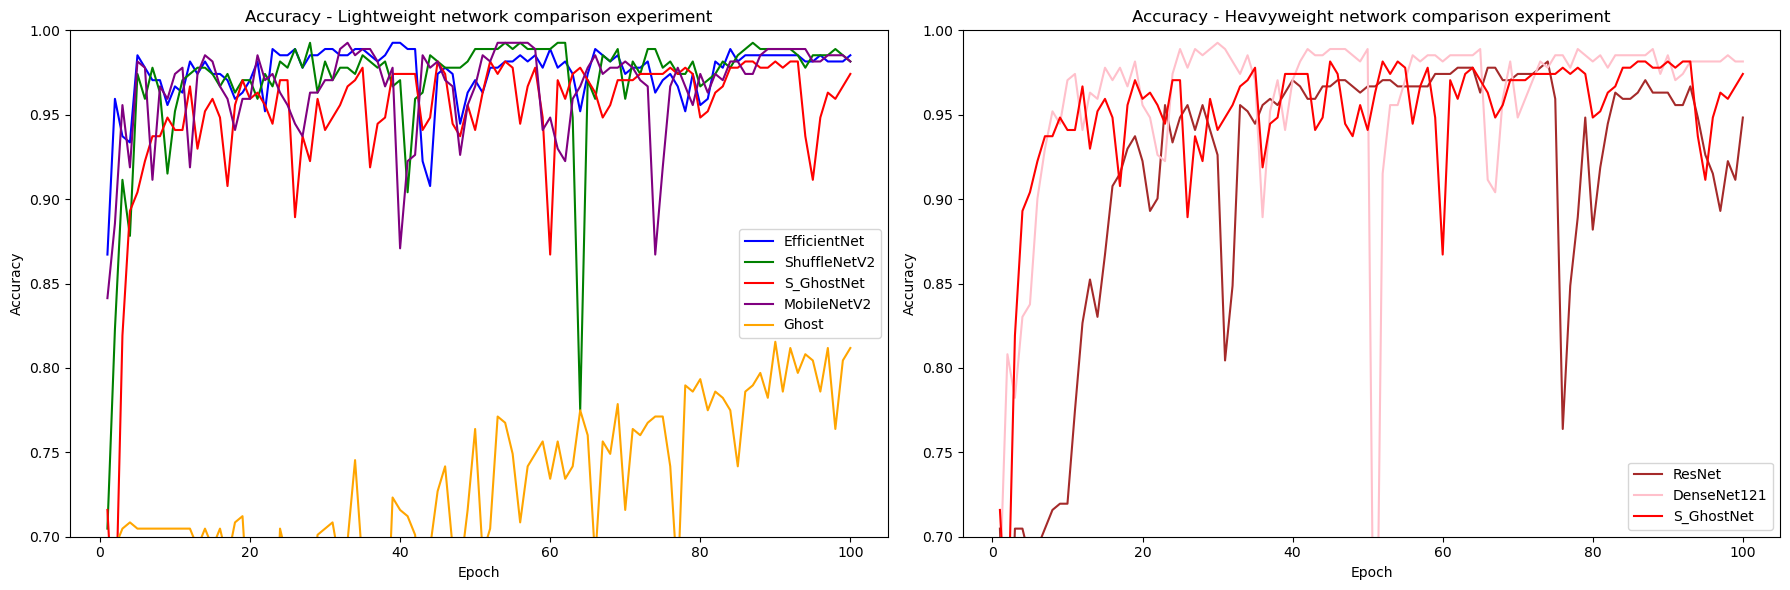

In [19]:
import matplotlib.pyplot as plt
import random
# 假设你的results已经定义并包含模型数据
# 格式应该是 results = {'model_name': {'accuracies': [...]}, ...}

# 设置图形布局
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 仅需要两个图

# 定义模型分组
model_groups = {
    'Lightweight network comparison experiment': ['EfficientNet', 'ShuffleNetV2',  'S_GhostNet','MobileNetV2','Ghost'],
    'Heavyweight network comparison experiment': [ 'ResNet', 'DenseNet121', 'S_GhostNet']
}

# 定义颜色映射，确保每种模型都有独特颜色
model_colors = {
    'EfficientNet': 'blue',
    'ShuffleNetV2': 'green',
    'Ghost': 'orange',
    'S_GhostNet': 'red',  # 选择一个明显的颜色
    'MobileNetV2': 'purple',
    'ResNet': 'brown',
    'DenseNet121': 'pink'
}

import matplotlib.pyplot as plt
import numpy as np

y_min, y_max, y_step = 0.7, 1, 0.05
y_ticks = [y / 100 for y in range(int(y_min * 100), int(y_max * 100) + 1, int(y_step * 100))]

# 绘制 Accuracy 图
for i, (group_name, models) in enumerate(model_groups.items()):
    ax = axes[i]
    for model_name in models:
        if model_name in results:
            accuracies = results[model_name]['accuracies']
            
            adjusted_accuracies = accuracies

            ax.plot(range(1, len(adjusted_accuracies) + 1), adjusted_accuracies, label=model_name,
                    color=model_colors.get(model_name, 'black'))

    ax.set_title(f'Accuracy - {group_name}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_yticks(y_ticks)
    ax.set_ylim(y_min, y_max)
    ax.legend()

plt.tight_layout()
plt.show()


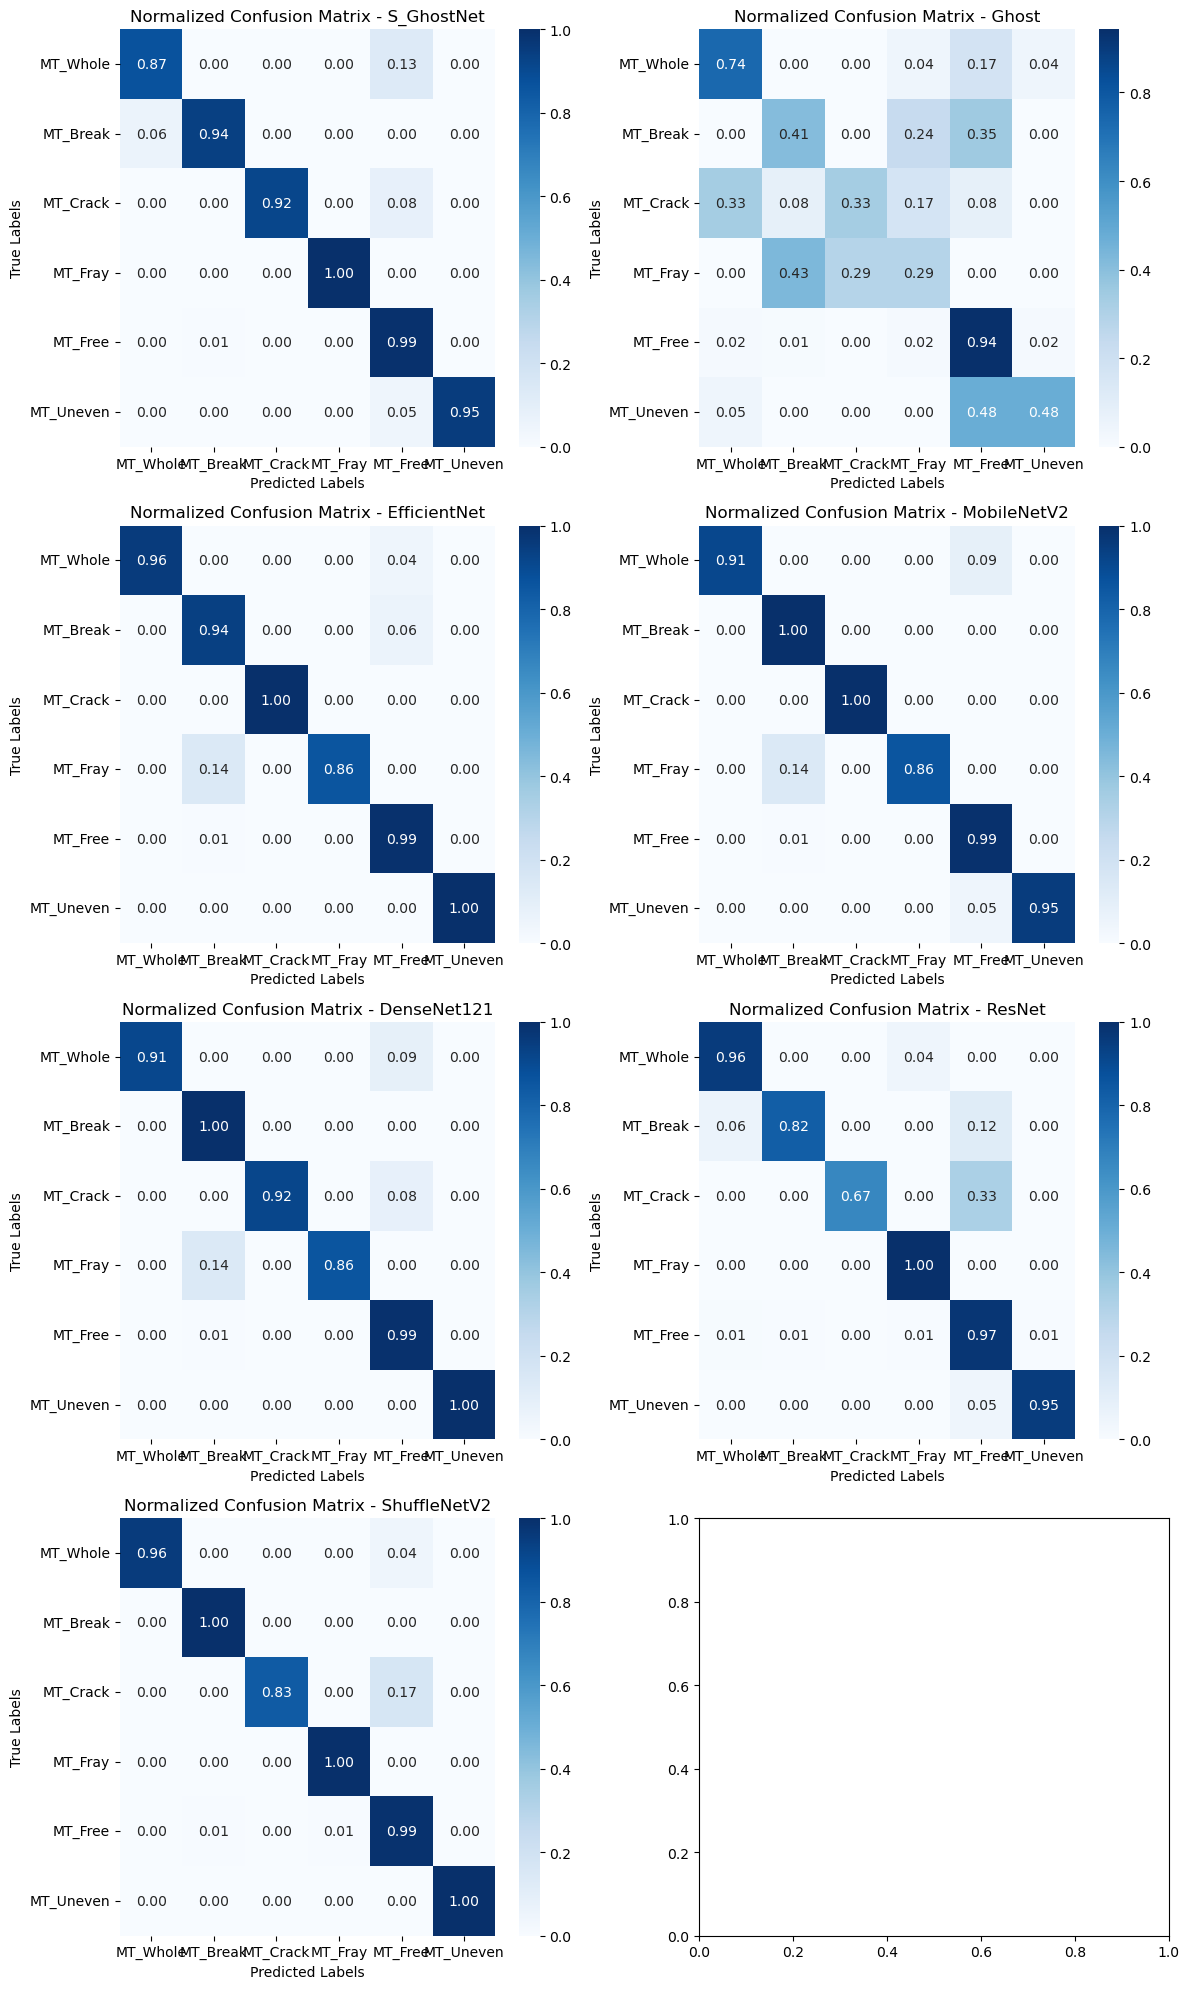

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


# 选择要绘制混淆矩阵的模型
models_to_plot = ['S_GhostNet',"Ghost",'EfficientNet', 'MobileNetV2', "DenseNet121", "ResNet","ShuffleNetV2"]

# 类别名称的映射
class_names = ['MT_Whole', 'MT_Break', 'MT_Crack', 'MT_Fray', 'MT_Free', 'MT_Uneven']

# 设置图形布局为三行两列
# fig, axes = plt.subplots(4, 2, figsize=(24, 12))  # 三行两列
fig, axes = plt.subplots(4, 2, figsize=(12, 20))  # 减小宽度，增加高度

# 遍历每个模型并绘制混淆矩阵
for i, model_name in enumerate(models_to_plot):
    ax = axes[i // 2, i % 2]  # 计算行和列索引
    
    # 加载模型
    model = model_dict[model_name]
    model = model.to(device)
    model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))
    model.eval()
    
    # 获取测试集数据
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_predicted)
    

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    

    
    # 使用seaborn绘制混淆矩阵热图
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax, xticklabels=class_names, yticklabels=class_names)
    
    # 设置横坐标标签为水平显示
    ax.set_xticklabels(class_names, rotation=0)
    
    ax.set_title(f'Normalized Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# 隐藏最后一个空的子图
# fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()